# [Intro to Raster Data in Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/)
# Chapter 4 Raster Data in Python

In this chapter we wil learn how to use the package **rasterio** combined with **numpy** and **earthpy** to open, manipulate and plot raster data.

We will learn about the key attributes of raster data:

1. Spatial resolution
1. Spatial extent and
1. Coordinate reference systems

## Intro to Rester Data

### What is a Raster
Raster or “gridded” data are stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth’s surface. A raster file is composed of regular grid of cells, all of which are the same size.

We’ve looked at and used rasters before if we’ve looked at photographs or imagery in a tool like Google Earth. However, the raster files that we will work with are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

*Fun Raster Notes*

* Each cell is called a pixel.
* And each pixel represents an area on the ground.
* The resolution of the raster represents the area that each pixel represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1 m area on the ground.

A raster dataset can have attributes associated with it as well. For instance, in a Lidar derived digital elevation model (DEM), each cell represents an elevation value for that location on the earth. In a Lidar derived intensity image, each cell represents a Lidar intensity value or the amount of light energy returned to and recorded by the sensor.

> Note: Light Detection and Ranging (LIDAR), is a remote sensing method that uses light in the form of a pulsed laser to measure ranges (variable distances) to the Earth.
> More info: [lidar remote sensing data and the various raster data products derived from lidar data.](https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/)

This means that Raster data can be used to store many different types of scientific data like:

* elevation data
* canopy height models
* surface temperature
* climate model data outputs
* landuse / landcover data






In [1]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and rasterio for raster data
import geopandas as gpd
import rasterio as rio
# Plotting extent is used to plot raster & vector data together
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

Digital Surface Model (DSM): Elevation at the tops of trees, buildings, etc 

Digital Terrain Model (DTM) or digital elevation model (DEM): Elevation of the earth's surface

Canopy Height Model (CHM): Actual height of trees, buildings, etc with the influence of the ground elevation removed

CHM = DSM-DTM

### Context Managers to Open and Close Fie Connections
A context manager allows us to open the data and work with it. Within the context manager, Python makes a temporary connection to the file.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory.

Once we are done opening and reading in the data, the context manager closes that connection to the file. This efficiently ensures that the file won’t be modified later in our code.

The parts of the context manaager are:

>> with rio.open('file-path-here') as file_src:
     dtm_pre_arr = dem_src.read(1, masked=True)

1. `with` statement: creates a connection to eh file. The default connection is read only, meaning that we cannot modify the file by default. This prevents us from making unintended changes to the original data.
1. `rio.open()`: will open a connection to the file with the path provided
1. `file_src`: this is a rasterio reader object that we can use to read in the actual data. We can also use this object to access the metadata for the raster file.
2. The second line of the statement is indented. Any line that is indented below the `with` statement will become part ot the context manager. 



In [16]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Define relative path to file
dem_pre_path = os.path.join("colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

with rio.open(dem_pre_path) as src:
    # Notice here the src object is printed and returns an "open" DatasetReader object
    print(src, "\n")

# Note that the src object is now closed because it's not within the indented
# part of the context manager above
print(src)

<open DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'> 

<closed DatasetReader name='colorado-flood/spatial/boulder-leehill-rd/pre-flood/lidar/pre_DTM.tif' mode='r'>


### Exercise
We are going to use the NEON (National Ecological Observatory Network) data

In [11]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Define relative path to file
dem_pre_path = os.path.join("colorado-flood", "spatial",
                              "boulder-leehill-rd", "pre-flood", "lidar",
                              "pre_DTM.tif")

# Open the file using a context manager ("with rio.open" statement)
with rio.open(dem_pre_path) as dem_src:
    dtm_pre_arr = dem_src.read(1)

print("Numpy Array Shape:", dtm_pre_arr.shape)
print("Object type:", type(dtm_pre_arr))

Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ndarray'>


When we open raster data using rasterio, we are creating a numpy array. Numpy is an efficient way to work with and process raster format data. We can plot our data using earthpy `plot_bands()` which takes a numpy array as an input and generates a plot.

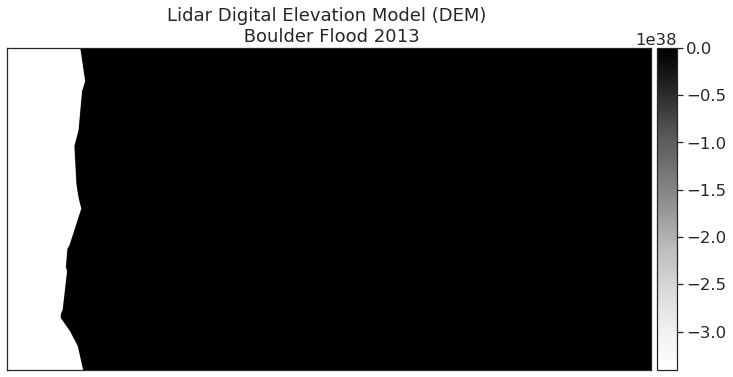

In [4]:
# Plot your data using earthpy
ep.plot_bands(dtm_pre_arr,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()


The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m.

There may be some outlier values in the data that may need to be addressed. Below we check out the min and max values of the data.

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


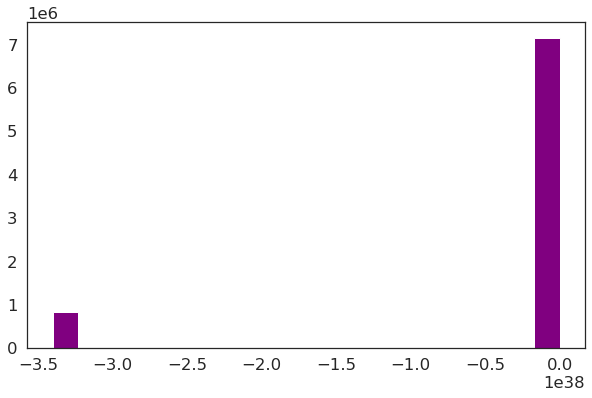

In [6]:
print("the minimum raster value is: ", dtm_pre_arr.min())
print("the maximum raster value is: ", dtm_pre_arr.max())

# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
ep.hist(dtm_pre_arr,
       figsize=(10,6))
plt.show()

Looking at the minimum value of the data, there are two things going on that need to be fixed:

* Check if there should be *nodata* values in the data. *nodata* or invalid elements are pixels we would like to ignore when, for example, merging the image with another image. The negative value of the *nodata* elements might be skewing our plot colors.
* there also could be outlier data in our raster

We can explore the first option - that there are no data values by reading in the data and masking no data values using rasterio. To do this, we will use the `masked=True` parameter for the `.read()` function.

The type of the numpy array created in this way will be `numpy.ma.core.MaskedArray` since we are using to mask the *nodata* values in our data. Masking ensures that when we plot or perfomr arithmetic operations with the data, those *nodata* values are not included in the operation.  

the minimum raster value is:  1676.21
the maximum raster value is:  2087.43
Numpy Array Shape: (2000, 4000)
Object type: <class 'numpy.ma.core.MaskedArray'>


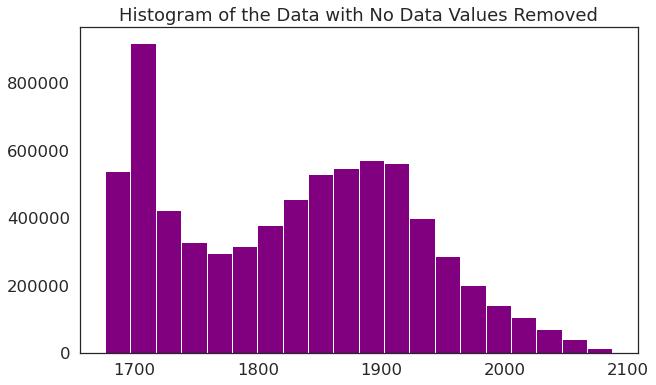

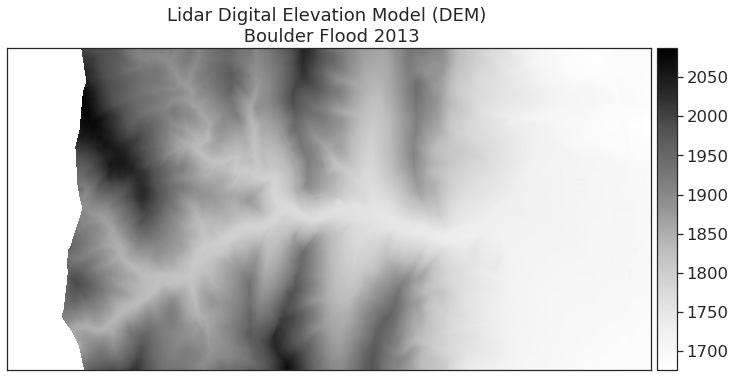

In [13]:
# Read in our data and mask the nodata values
with rio.open(dem_pre_path) as dem_src:
    # Masked=True will mask all nodata values
    lidar_dem_im = dem_src.read(1, masked=True)


print("the minimum raster value is: ", lidar_dem_im.min())
print("the maximum raster value is: ", lidar_dem_im.max())

print("Numpy Array Shape:", lidar_dem_im.shape)
print("Object type:", type(lidar_dem_im))

# A histogram can also be helpful to look at the range of values in our data
ep.hist(lidar_dem_im,
       figsize=(10,6),
       title="Histogram of the Data with No Data Values Removed")
plt.show()

# Plot data using earthpy
ep.plot_bands(lidar_dem_im,
              title="Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013",
              cmap="Greys")

plt.show()

Now the minimum value is within the expected range. Plotting the data again displays what we were expecting.

### Spatial Metadata
A numpy array does not by default store spatial information. However, our raster data is spatial - it represents a location on the earth’s surface.

We can acccess the spatial metadata within the context manager using dem_src.profile. Notice that the .profile object contains information including the *nodata* values for our data, the shape the file type and even the coordinate reference system.

In [14]:
with rio.open(dem_pre_path) as dem_src:
    # lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_meta = dem_src.profile

lidar_dem_meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 4000, 'height': 2000, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(1.0, 0.0, 472000.0,
       0.0, -1.0, 4436000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Plot Raster and Vector Data Together

To plot raster and vector data together on a map, we will need to create an extent object that defines the spatial extent of our raster layer. This will then allow us to plot a raster and vector data together to create a map.

*Exercise* 
We will open a single shapefile that contains a boundary layer that we can overlay on top of our raster dataset.


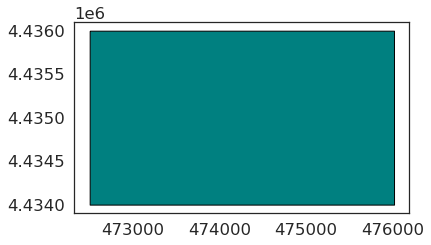

In [17]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
site_bound_shp.plot(color='teal',
                    edgecolor='black')
plt.show()

We could try to plot the two datasets together but, since the raster layer does not have spatial information associated with it, the output would look wrong.

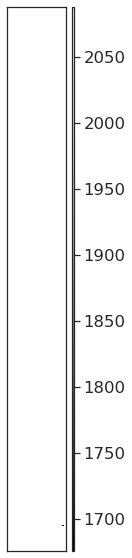

In [18]:
# fig, ax = plt.subplots(figsize=(4,10))

# ep.plot_bands(dtm_pre_arr, ax=ax)

# site_bound_shp.plot(color='teal',
#                     edgecolor='black', ax=ax)

# plt.show()

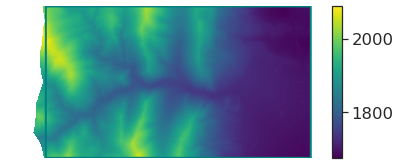

In [24]:
with rio.open(dem_pre_path) as dem_src:
    lidar_dem_im = dem_src.read(1, masked=True)
    # Create an object called lidar_dem_meta that contains the spatial metadata
    lidar_dem_plot_ext = plotting_extent(dem_src)

# This plotting extent object will be used below to ensure our data overlay correctly
lidar_dem_plot_ext

fig, ax = plt.subplots()

#the extent= parameter specifies the plotting extent within ep.plot_bands()
ep.plot_bands(dtm_pre_arr,
              ax=ax,
              extent=lidar_dem_plot_ext,
              cmap = 'viridis')

site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax)
# Turn off the outline or axis border on your plot
ax.axis('off')
plt.show()

## Open Raster Data